In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Lấy dữ liệu
Dữ liệu từ 20 000 ván đấu cờ vua online trên hệ thống Lichess.org bao gồm các nước đi, rating, khai cuộc,...  
https://www.kaggle.com/datasnaek/chess  
License: CC0 1.0 Universal (CC0 1.0)    
Dữ liệu gốc được thu thập từ Lichess API

# Khám phá dữ liệu

## Đọc dữ liệu vào dataframe

In [2]:
games_df = pd.read_csv('games.csv')
games_df.head()

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
0,TZJHLljE,False,1.504210e+12,1.504210e+12,13,outoftime,white,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5
1,l1NXvwaE,True,1.504130e+12,1.504130e+12,16,resign,black,5+10,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4
2,mIICvQHh,True,1.504130e+12,1.504130e+12,61,mate,white,5+10,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3
3,kWKvrqYL,True,1.504110e+12,1.504110e+12,61,mate,white,20+0,daniamurashov,1439,adivanov2009,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,Queen's Pawn Game: Zukertort Variation,3
4,9tXo1AUZ,True,1.504030e+12,1.504030e+12,95,mate,white,30+3,nik221107,1523,adivanov2009,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,Philidor Defense,5


## Kích thước của dữ liệu

In [3]:
num_rows,num_cols = games_df.shape
print(f'Dữ liệu có {num_cols} cột')
print(f'Dữ liệu có {num_rows} dòng')

Dữ liệu có 16 cột
Dữ liệu có 20058 dòng


## Ý nghĩa của mỗi dòng

Mỗi dòng chứa thông tin về một ván đấu cờ vua trên hệ thống Lichess

## Ý nghĩa của mỗi cột
* id: ID của ván đấu trên Lichess
* rated: Ván đấu có được tính xếp hạng hay không?
* create_at: Thời điểm bắt đầu ván đấu
* last_move_at: Thời điểm người chơi đi nước đi cuối
* turns: Số nước đi của ván đấu
* victory_status: lí do chiến thắng (mate: chiếu hết, resign: chịu thua, outoftime: hết thời gian trên đồng hồ, stalemate: hòa hết nước đi, ...)
* winner: người chiến thắng (white, black, draw lần lượt là quân trắng, quân đen, hòa)
* increment_code: Nếu thắng ván đấu, người chơi sẽ được cộng bao nhiêu điểm rating, trước dấu cộng là điểm cộng cho người cầm quân trắng, sau dấu cộng là điểm cộng cho người cầm quân đen
* white_id: id của người cầm quân trắng trên Lichess
* white_rating: rating của người cầm quân trắng
* black_id: id của người cầm quân đen trên Lichess
* black_rating: rating của người cầm quân đen
* moves: các nước đi trong ván đấu
* opening_eco: Mã chuẩn hóa của khai cuộc của ván đấu (tham khảo ở: https://www.365chess.com/eco.php)
* opening_name: tên khai cuộc
* opening_ply: số nước đi ở giai đoạn khai cuộc

## Kiểu dữ liệu mỗi cột

In [4]:
games_df.dtypes

id                 object
rated                bool
created_at        float64
last_move_at      float64
turns               int64
victory_status     object
winner             object
increment_code     object
white_id           object
white_rating        int64
black_id           object
black_rating        int64
moves              object
opening_eco        object
opening_name       object
opening_ply         int64
dtype: object

Ta có cột create_at và last_move_at là timestamp của ván đấu, tuy nhiên không có ý nghĩa gì nhiều trong quá trình phân tích nên ta không xử lý 2 cột này

## Miền dữ liệu của các cột có kiểu dữ liệu dạng numerical

In [5]:
cols_numerical = [label for label in games_df.dtypes[games_df.dtypes!='object'].index]
cols_categorical = [label for label in games_df.dtypes[games_df.dtypes == 'object'].index]

In [6]:
numerical_range = pd.DataFrame({'min': games_df[cols_numerical].min(),
                              'max':games_df[cols_numerical].max()})
numerical_range

,min,max
rated,False,True
created_at,1.37677e+12,1.50449e+12
last_move_at,1.37677e+12,1.50449e+12
turns,1,349
white_rating,784,2700
black_rating,789,2723
opening_ply,1,28


## Các giá trị có thể có của các cột dạng categorical

In [7]:
categorical_unique_vals = pd.DataFrame({'Unique values' :games_df[cols_categorical].apply(lambda r: r.unique())
                                        ,'Count unique values': games_df[cols_categorical].nunique()})
categorical_unique_vals

,Unique values,Count unique values
id,"[TZJHLljE, l1NXvwaE, mIICvQHh, kWKvrqYL, 9tXo1...",19113
victory_status,"[outoftime, resign, mate, draw]",4
winner,"[white, black, draw]",3
increment_code,"[15+2, 5+10, 20+0, 30+3, 10+0, 15+30, 15+0, 20...",400
white_id,"[bourgris, a-00, ischia, daniamurashov, nik221...",9438
black_id,"[a-00, skinnerua, adivanov2009, franklin14532,...",9331
moves,[d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba...,18920
opening_eco,"[D10, B00, C20, D02, C41, B27, D00, C50, B01, ...",365
opening_name,"[Slav Defense: Exchange Variation, Nimzowitsch...",1477


## Các giá trị thiếu?

In [8]:
games_df.isna().sum()

id                0
rated             0
created_at        0
last_move_at      0
turns             0
victory_status    0
winner            0
increment_code    0
white_id          0
white_rating      0
black_id          0
black_rating      0
moves             0
opening_eco       0
opening_name      0
opening_ply       0
dtype: int64

May mắn là không có cột nào bị thiếu trong dữ liệu

# Các câu hỏi từ dữ liệu
1. Nước đi đầu tiên hay được dùng là gì? Tại sao?
    * Nên đi nước đi đầu tiên như thế nào để phục vụ ý đồ của bạn?

2. Những khai cuộc phổ biến nhất là gì? Tỉ lệ thắng của các bên trong những khai cuộc đó là bao nhiêu?
    * Tìm được cách đánh khai cuộc tốt từng loại quân

3.  Việc lựa chọn khai cuộc có ảnh hưởng tới độ dài ván đấu hay không? Với những khai cuộc thường thấy, khai cuộc nào làm cho ván đấu có tiết tấu nhanh nhất, khai cuộc nào làm cho ván đấu có tiết tấu chậm nhất?
    * Khi theo dõi những trận đấu cờ vua, ta nên theo dõi những ván đấu sử dụng khai cuộc gì để khỏi phải nhàm chán (ván đấu quá dài, kết quả hòa,...)

4.  Khi phải đối đầu với một người chơi có trình độ cao hơn, ta nên lựa chọn khai cuộc nào để chiến thắng?
    * Lựa chọn khai cuộc như thế nào khi gặp đối thủ có trình độ cao hơn mình
5.  Những ván đấu mà 2 người chơi ở trình độ cao (rating trung bình của ván đấu > 2000) thì thường sử dụng khai cuộc nào?
    * Học hỏi cách chơi khai cuộc cờ vua từ những cao thủ


# Phân tích dữ liệu trả lời cho các câu hỏi trên

## Những lựa chọn cho nước đi đầu tiên

### Trích ra nước đi đầu tiên của mỗi ván đấu từ cột moves

In [9]:
games_df = games_df.assign(first_move = lambda row: row['moves'].str.split(' ').str[0])

### Vẽ biểu đồ các nước đi đầu tiên được sử dụng nhiều như thế nào

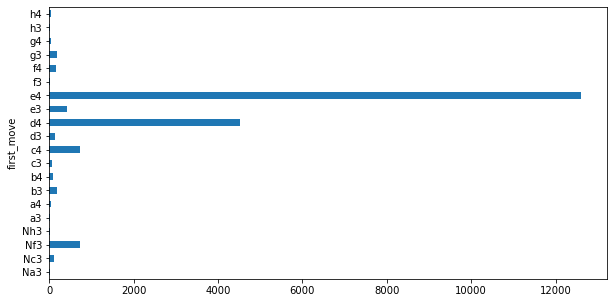

In [10]:
first_move_df = games_df.groupby('first_move').size()
first_move_df.plot(kind='barh', figsize=(10,5))
plt.show()

#### Nhận xét
Như vậy nước e4 là nước cờ được lựa chọn nhiều nhất khi bắt đầu ván cờ
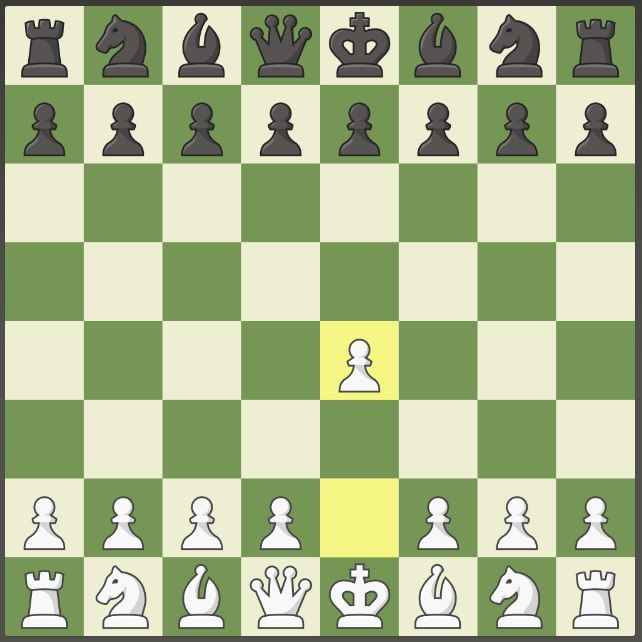**1 e4 - King's Pawn Opening**  
Ngoài ra nước d4 cũng khá được ưa chuộng
Ta thấy 4 nước cờ thường được sử dụng làm nước đi đầu tiên là: e4, d4, c4, Nf3  
#### Giải thích:
* e4: là nước cờ đưa tốt lên ô e4 nhằm đánh chiếm trung tâm, đồng thời mở đường cho Hậu và Tượng đen vào trận
* d4: là nước cờ đưa tốt lên d4 nhằm đánh chiếm trung tâm, mở đường cho tượng trắng vào trận
* c4: là nước cờ đưa tốt lên ô c4 nhằm kiểm soát ô d5 ở trung tâm đối thủ, thực hiện cho ý đồ tạm thời nhường trung tâm cho đối thủ để phản công về sau
* Nf3: là nước phi mã lên f3 để kiểm soát trung tâm  
**Kết luận: Các nước đi trên đều là các nước đi nhằm kiểm soát, đánh chiếm trung tâm**
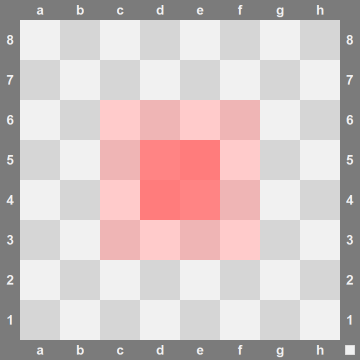  
(*) Trung tâm trong cờ vua là vùng gồm những ô màu đỏ trên bàn cờ ở trên, việc chiếm được trung tâm là tiền đề để đưa các quân mạnh vào trận và phát huy tối đa hiệu quả của các quân đó

## Các khai cuộc thông dụng nhất và tỉ lệ thắng của các bên trong những khai cuộc đó

### 20 khai cuộc được sử dụng nhiều nhất

#### Lấy ra 20 khai cuộc sử dụng nhiều nhất sắp xếp theo thứ tự giảm dần

In [11]:
top20_opening_df = games_df.groupby(['opening_name'])['opening_name'].agg(['count']).sort_values(by = 'count',ascending = False).head(20).sort_values(by = 'count',ascending = True)



#### Vẽ biểu đồ

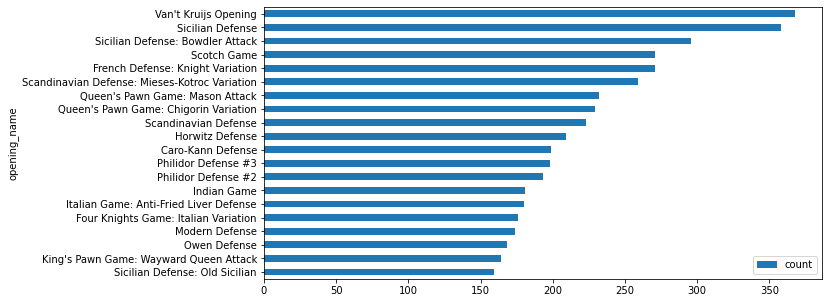

In [12]:
top20_opening_df.plot(kind ='barh',figsize = (10,5))
plt.show()

#### Nhận xét
Trên đây là 20 khai cuộc được sử dụng nhiều nhất, có thể thấy Van't Kruijs Opening là khai cuộc được dùng nhiều nhất. Tuy nhiên khai cuộc Sicilian Defense cũng có tới 3 biến thể nằm trong top 20 (Sicilian Defense, Sicilian Defense: Bowdler Attack, và Sicilian Defense: Old Sicilian)

### Tỉ lệ thắng của các bên theo từng loại khai cuộc

#### Gom nhóm theo các khai cuộc và bên thắng

In [13]:
winner_by_opening_df = games_df.groupby(['opening_name','winner']).size()
winner_by_opening_df

opening_name                     winner
Alekhine Defense                 black     21
                                 draw       2
                                 white     23
Alekhine Defense #2              black      1
                                 draw       1
                                           ..
Zukertort Opening: The Walrus    white      1
Zukertort Opening: Vos Gambit    black      1
                                 draw       1
                                 white      1
Zukertort Opening: Wade Defense  black      1
Length: 2739, dtype: int64

#### Unstack dataframe ở trên thành dataframe khác với 3 cột ứng với 3 kết quả ván đấu và opening_name ứng với tên khai cuộc

In [24]:
winner_by_opening_df_uns = winner_by_opening_df.unstack().dropna()
winner_by_opening_df_uns

winner,black,draw,white
opening_name,,,
Alekhine Defense,21.0,2.0,23.0
Alekhine Defense #2,1.0,1.0,1.0
Alekhine Defense: Maroczy Variation,8.0,1.0,10.0
Alekhine Defense: Mokele Mbembe,2.0,1.0,9.0
Alekhine Defense: Normal Variation,9.0,1.0,7.0
...,...,...,...
Zukertort Opening: Queenside Fianchetto Variation,3.0,6.0,9.0
Zukertort Opening: Ross Gambit,2.0,2.0,13.0
Zukertort Opening: Sicilian Invitation,21.0,3.0,18.0


#### Tính tổng các ván đấu sử dụng khai cuộc và tỉ lệ thắng của từng quân

In [ ]:
winner_by_opening_df_uns['sum']=winner_by_opening_df_uns['black']+winner_by_opening_df_uns['white']+winner_by_opening_df_uns['draw']

winner_by_opening_df_uns['black_winrate']= winner_by_opening_df_uns['black']/winner_by_opening_df_uns['sum']*100
winner_by_opening_df_uns['white_winrate']= winner_by_opening_df_uns['white']/winner_by_opening_df_uns['sum']*100
winner_by_opening_df_uns['draw_rate']= winner_by_opening_df_uns['draw']/winner_by_opening_df_uns['sum']*100

#### In ra bảng các khai cuộc và tỉ lệ thắng của từng loại quân, sắp xếp theo số lần sử dụng của khai cuộc

In [14]:
winrate_by_opening_df = winner_by_opening_df_uns.sort_values(by = 'sum',ascending=False).head(20)[['black_winrate','white_winrate','draw_rate']]
cm = sns.light_palette("green", as_cmap=True)
winrate_by_opening_df.style.background_gradient(cmap=cm)

winner,black_winrate,white_winrate,draw_rate
opening_name,,,
Van't Kruijs Opening,61.413043,34.239130,4.347826
Sicilian Defense,54.189944,41.620112,4.189944
Sicilian Defense: Bowdler Attack,55.405405,40.202703,4.391892
French Defense: Knight Variation,44.649446,49.815498,5.535055
Scotch Game,42.435424,53.505535,4.059041
Scandinavian Defense: Mieses-Kotroc Variation,34.362934,63.320463,2.316602
Queen's Pawn Game: Mason Attack,44.396552,50.000000,5.603448
Queen's Pawn Game: Chigorin Variation,47.598253,48.908297,3.493450
Scandinavian Defense,55.156951,40.358744,4.484305


#### Nhận xét
- Nhìn vào bảng trên ta thấy, khai cuộc mà bên quân đen có tỉ lệ thắng cao nhất là Van't Kruijs Opening, Philidor Defense #3 và khai cuộc có tỉ lệ hòa cao nhất là Indian Game  
- Một điều khá thú vị là Scandinavian Defense đem lại tỉ lệ thắng là 55% cho bên đen tuy nhiên biến thể của nó là Scandinavian Defense: Mieses-Kotroc Variation lại đem lại tỉ lệ thắng rất cao cho bên trắng (64%) => Scandinavian Defense là một khai cuộc khá mạo hiểm cho bên đen khi người chơi có thể nhầm lẫn giữa 2 biến thể đem lại tỉ lệ thắng ngược nhau như thế này

### Kết luận
- Van't Kruijs là khai cuộc được sử dụng nhiều nhất
- Đối với người cầm quân trắng, nên sử dụng khai cuộc Philidor Defense #3 và Scandinavian Defense: Mieses-Kotroc Variation để giành chiến thắng
- Đối với người cầm quân đen, nên sử dụng Van't Kruijs Opening

## Mối liên hệ giữa việc lựa chọn khai cuộc và độ dài ván đấu

#### Lấy trung vị của các ván đấu theo từng loại khai cuộc

In [15]:
top_20_count_opening_average_moves_df = games_df.groupby('opening_name')['turns'].agg([np.median,'count']).sort_values(by = ['count'],ascending = [False]).head(20)


#### Vẽ biểu đồ trung vị của từng loại khai cuộc

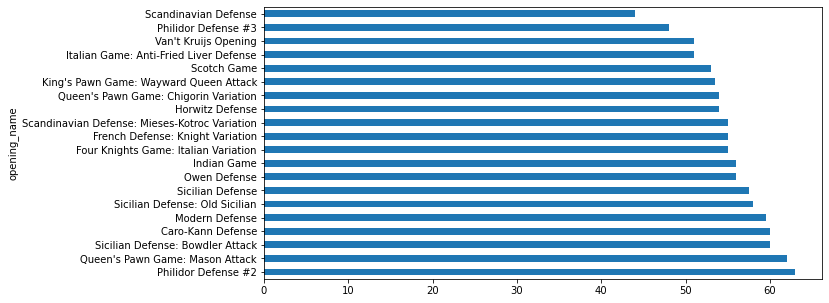

In [16]:
top_20_count_opening_average_moves_df['median'].sort_values(ascending = False).plot(kind = 'barh', figsize = (10,5))
#ax.grid(b=True, color='grey', linestyle='-.', linewidth=0.5, alpha=0.2)

plt.show()

### Kết luận
Trong 20 khai cuộc được dùng nhiều nhất, Scandinavian Defense là khai cuộc mà trận đấu kết thúc nhanh nhất còn Philidor Defense #2 là khai cuộc mà ván đấu thường kéo dài nhất

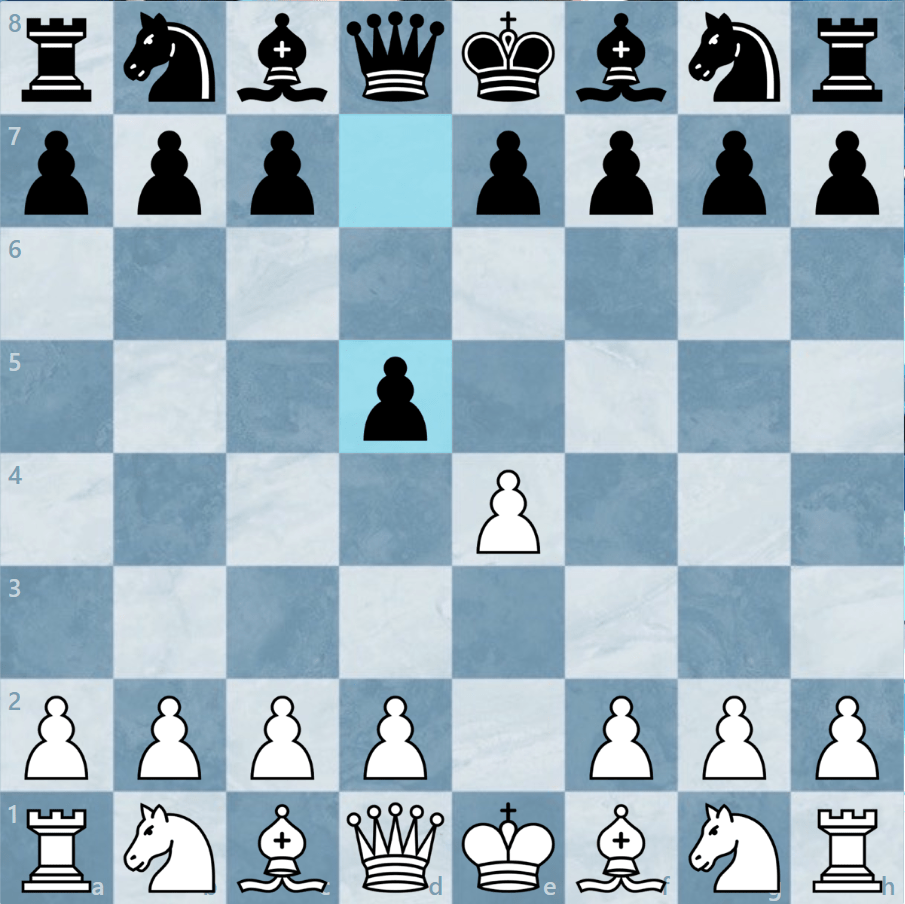  **Scandinavian Defense**


## Là một người chơi yếu hơn, ta nên lựa chọn khai cuộc nào để chiến thắng?

### Tạo cột mới kiểm tra xem một ván đấu có người chơi có rating cao hơn thắng

In [17]:
def isHigherRatingWins(row):
    if row.winner == 'black':
        if row.black_rating> row.white_rating:
            return True
        else:
            return False
    else:
        if row.black_rating> row.white_rating:
            return False
        else:
            return True
        

In [18]:
games_df['higher_wins'] = games_df.apply(isHigherRatingWins,axis = 1)
games_df

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply,first_move,higher_wins
0,TZJHLljE,False,1.504210e+12,1.504210e+12,13,outoftime,white,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5,d4,True
1,l1NXvwaE,True,1.504130e+12,1.504130e+12,16,resign,black,5+10,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4,d4,False
2,mIICvQHh,True,1.504130e+12,1.504130e+12,61,mate,white,5+10,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3,e4,False
3,kWKvrqYL,True,1.504110e+12,1.504110e+12,61,mate,white,20+0,daniamurashov,1439,adivanov2009,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,Queen's Pawn Game: Zukertort Variation,3,d4,False
4,9tXo1AUZ,True,1.504030e+12,1.504030e+12,95,mate,white,30+3,nik221107,1523,adivanov2009,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,Philidor Defense,5,e4,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20053,EfqH7VVH,True,1.499791e+12,1.499791e+12,24,resign,white,10+10,belcolt,1691,jamboger,1220,d4 f5 e3 e6 Nf3 Nf6 Nc3 b6 Be2 Bb7 O-O Be7 Ne5...,A80,Dutch Defense,2,d4,True
20054,WSJDhbPl,True,1.499698e+12,1.499699e+12,82,mate,black,10+0,jamboger,1233,farrukhasomiddinov,1196,d4 d6 Bf4 e5 Bg3 Nf6 e3 exd4 exd4 d5 c3 Bd6 Bd...,A41,Queen's Pawn,2,d4,False
20055,yrAas0Kj,True,1.499698e+12,1.499698e+12,35,mate,white,10+0,jamboger,1219,schaaksmurf3,1286,d4 d5 Bf4 Nc6 e3 Nf6 c3 e6 Nf3 Be7 Bd3 O-O Nbd...,D00,Queen's Pawn Game: Mason Attack,3,d4,False
20056,b0v4tRyF,True,1.499696e+12,1.499697e+12,109,resign,white,10+0,marcodisogno,1360,jamboger,1227,e4 d6 d4 Nf6 e5 dxe5 dxe5 Qxd1+ Kxd1 Nd5 c4 Nb...,B07,Pirc Defense,4,e4,True


### Tỉ lệ thắng của bên có rating cao hơn trong một ván đấu

In [25]:
#Gom nhóm số lượng các ván đấu theo cột higher_wins vừa tạo ở trên
higher_rating_wins = games_df.groupby('higher_wins').size()


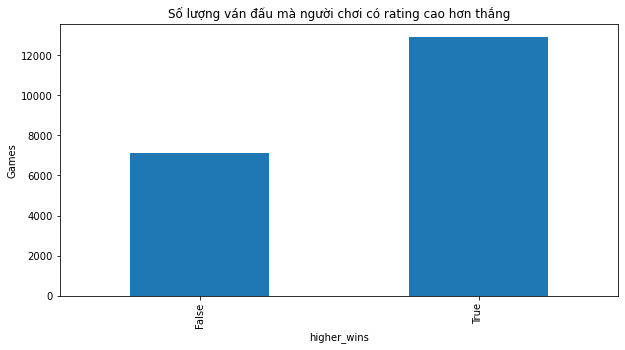

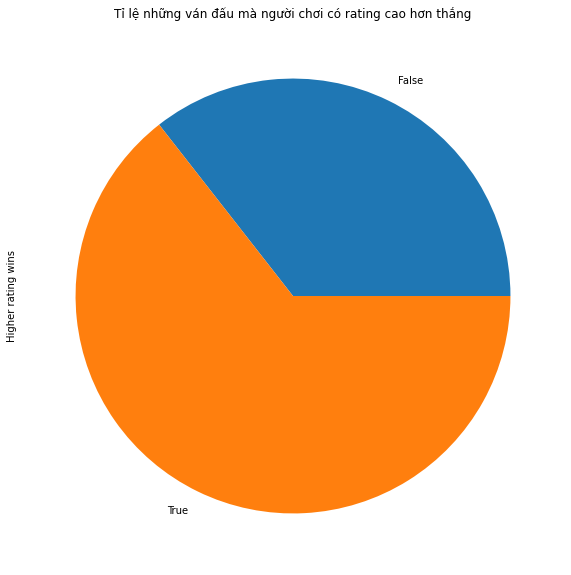

In [26]:
#Vẽ biểu đồ cột
higher_rating_wins.plot(kind = 'bar', ylabel = 'Games',title = 'Số lượng ván đấu mà người chơi có rating cao hơn thắng',figsize = (10,5))
plt.show()
#Vẽ biểu đồ quạt
higher_rating_wins.plot(kind = 'pie', ylabel='Higher rating wins',title= 'Tỉ lệ những ván đấu mà người chơi có rating cao hơn thắng',figsize = (10,10))
plt.show()


#### Nhận xét
Nhìn vào biểu đồ ta dễ dàng thấy số lượng ván đấu mà người chơi có rating cao hơn thắng so là gần gấp đôi so với số ván đấu mà người chơi có rating thấp hơn thắng  
Ta thử phân tích xem những ván mà người chơi rating thấp hơn thắng họ thường sử dụng những khai cuộc nào

### Khai cuộc trong các ván đấu mà người chơi có rating thấp hơn thắng

#### Lấy ra những ván đấu người chơi có rating thấp hơn thắng

In [20]:
lower_rating_wins_games_df = games_df[games_df['higher_wins']==False]
opening_used_by_lower_rating = lower_rating_wins_games_df.groupby('opening_name').size().sort_values(ascending = False).head(20)

#### Vẽ biểu đồ theo từng loại khai cuộc được dùng trong các ván đấu đó

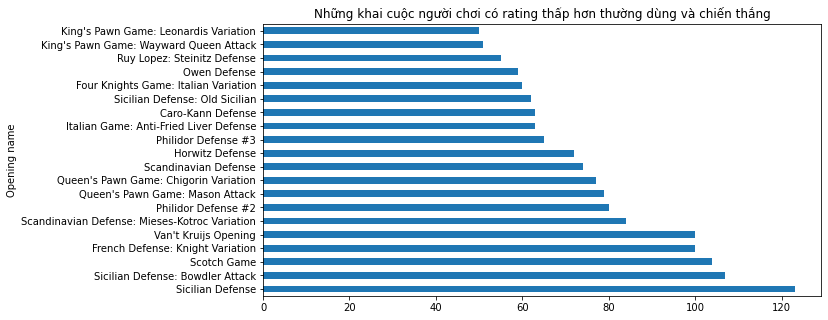

In [21]:
opening_used_by_lower_rating.plot(kind= 'barh', ylabel='Games',xlabel='Opening name',title='Những khai cuộc người chơi có rating thấp hơn thường dùng và chiến thắng',figsize =(10,5))
plt.show()

### Kết luận
Nhìn vào biểu đồ ta thấy, với một người có rating thấp hơn thì những khai cuộc như Sicilian Defense với các biến thể của nó, Scotch Game và French Defense là một sự lựa chọn tốt khi phải đối đầu với người chơi có trình độ cao hơn

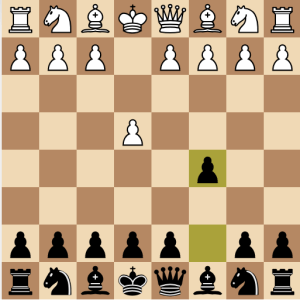 **Sicilian Defense**

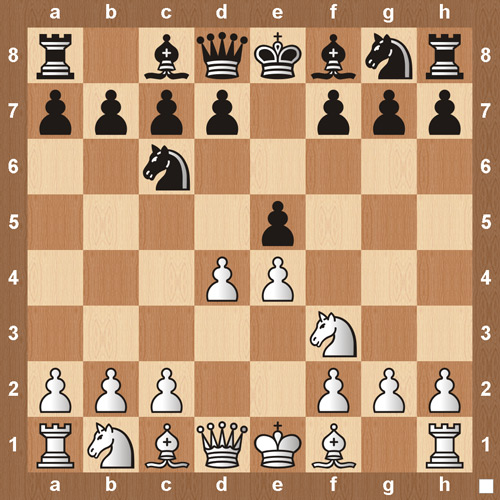 **Scotch game**

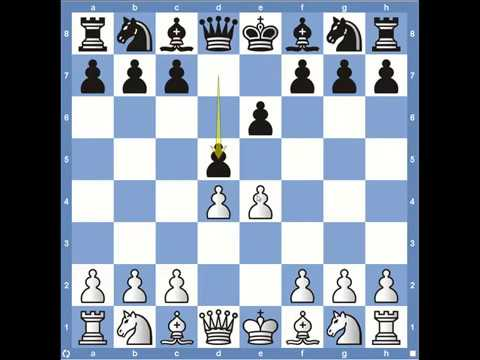 **French Defense**

## Khai cuộc của những ván đấu rating cao (average_rating >2000)

### Tính average_rating bằng trung bình của black rating và white rating

In [22]:
games_df['average_rating'] = (games_df['black_rating'] + games_df['white_rating'])//2

#### Vẽ biểu đồ số lần sử dụng các khai cuộc trong các ván đấu có average_rating > 2000

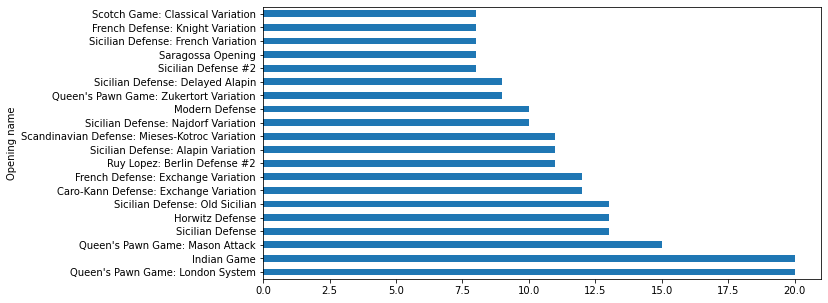

In [23]:
gt_2000_games_df = games_df[games_df['average_rating']>2000]
opening_gt_2000_df = gt_2000_games_df.groupby('opening_name').size().sort_values(ascending = False)
opening_gt_2000_df.head(20).plot(kind='barh',xlabel ='Opening name',figsize =(10,5))
plt.show()

### Kết luận
Với tầm rating cao thì những khai cuộc như Queen's Pawn Game: London System và Indian Game thường được ưa chuộng, khác với mẫu chung là Van't Krujis và Sicilian Defense

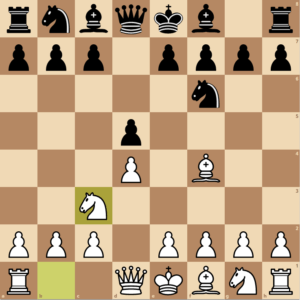 **London system**

# Tổng kết

Qua bài phân tích trên, hi vọng các bạn có thể tìm được một khai cuộc trong cờ vua mà mình thích cũng như lựa chọn một đối pháp hợp lí cho đối thủ của mình

# Trải nghiệm khi thực hiện đồ án

## Thuận lợi

* Dữ liệu đầy đủ các feature, không cần trải qua bước tiền xử lý
* Dễ dàng rút trích ra các feature mới từ các feature đã có của dữ liệu

## Khó khăn
* Đề tài cần kiến thức về cờ vua để thực hiện


### Nếu có thêm thời gian em sẽ
- Phân tích thêm về việc nhập thành và ảnh hưởng của nó đối với việc thắng trận dựa trên feature moves
- Phân tích tiết tấu của những ván đấu theo từng loại khai cuộc dựa trên 20, 30 moves đầu tiên có chữ x (trong kí hiệu cờ vua, nước cờ có chữ x là nước ăn quân)

## Công cụ sử dụng
* Pandas
* Numpy
* Matplotlib
* Seaborn

## Tham khảo
* StackOverFlow
* Pandas documents
